# 🎯 Scene Localization in Dense Images via Natural Language Queries (Single Query)

This notebook uses **OpenAI's CLIP** model to locate and crop a sub-scene in a dense image based on a natural language query.

### Steps:
1. Install dependencies
2. Load CLIP model
3. Upload image and provide text query
4. Display the best matching region

In [1]:
!pip install git+https://github.com/openai/CLIP.git --quiet
!pip install Pillow matplotlib --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 885.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00


In [2]:
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load('ViT-B/32', device=device)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 105MiB/s]


Saving street.jpg to street.jpg


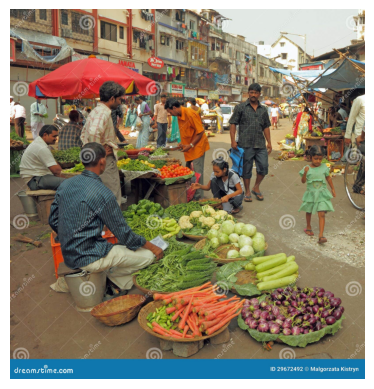

In [3]:
# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
# Enter your query
query = input('Enter your text query: ')
text_tokens = clip.tokenize([query]).to(device)

Enter your text query: a girl in green dress


Best match score: 0.2974


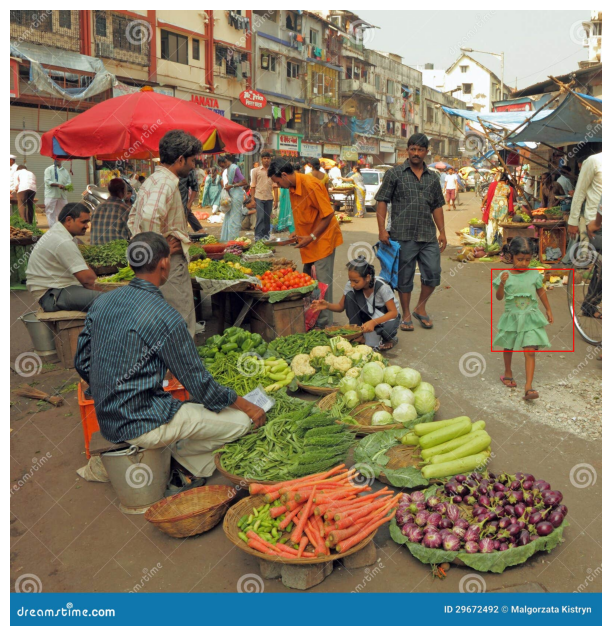

In [6]:
from PIL import ImageDraw
import matplotlib.pyplot as plt

window_size = 224
stride = 100
best_score = -1
best_box = None  # store coordinates of best window

# Make a copy of the original image for drawing
draw_image = image.copy()
draw = ImageDraw.Draw(draw_image)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for y in range(0, image.height - window_size, stride):
        for x in range(0, image.width - window_size, stride):
            crop = image.crop((x, y, x+window_size, y+window_size))
            image_input = preprocess(crop).unsqueeze(0).to(device)
            image_features = model.encode_image(image_input)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = (image_features @ text_features.T).item()
            if similarity > best_score:
                best_score = similarity
                best_box = (x, y, x+window_size, y+window_size)

# Draw rectangle for best matching window
if best_box is not None:
    draw.rectangle(best_box, outline="red", width=3)

print(f"Best match score: {best_score:.4f}")
plt.figure(figsize=(8,8))
plt.imshow(draw_image)
plt.axis('off')
plt.show()
